In [21]:
import torch
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class CFG1:
  k = 10
  reward_means = torch.randint(-3, 8, (k,)).float()
  reward_stds = torch.rand(k) + 3.0
  eps = 0.1
  iterations = 1000
  experiments = 2000

In [3]:
class kArmedTestBed:
  def __init__(self, cfg):
    self.cfg = cfg
    self.k = cfg.k
    self.actions = [i for i in range(1, self.k + 1)]
    self.reward_means = cfg.reward_means
    self.reward_stds = cfg.reward_stds
    self.rewards_store = [[] for _ in range(self.k)]

  def populate_rewards(self, samples_per_distribution=1000):
    for action in range(self.k):
      for _ in range(samples_per_distribution):
        self.rewards_store[action].append(self.claim_reward(action))

  def rewards(self):
    return self.rewards_store

  def claim_reward(self, action):
    return torch.normal(self.reward_means[action], self.reward_stds[action]).item()

  def plot_rewards_distribution(self):
    data = [self.rewards_store[i] for i in range(self.k)]

    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=data, inner="quartile", color='#4A90E2', edgecolor='#2E6DA4')
    plt.xticks(ticks=range(self.k), labels=self.actions)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
    plt.xlabel('Action')
    plt.ylabel('Reward distribution')
    plt.title('Reward Distribution by Action')

    plt.tight_layout()
    plt.show()

In [28]:
class Bandit:
  def __init__(self, cfg):
    self.k = cfg.k
    self.actions = [i for i in range(self.k)]
    self.test_bed = kArmedTestBed(cfg)
    self.test_bed.populate_rewards()
    self.exploration = cfg.exploration
    if self.exploration == 'ucb':
      self.c = cfg.c
    else:
      self.c = None
    if self.exploration == 'oiv':
      self.Q = [cfg.optimistic_initialization for _ in range(self.k)]
    else:
      self.Q = [0 for _ in range(self.k)]
    self.N = [0 for _ in range(self.k)]
    self.eps = cfg.eps
    self.rewards_accumulated = []
    self.iterations = cfg.iterations

  def one_run(self):
    if self.exploration != 'ucb':
      if random.random() < self.eps:
        action = random.choice(self.actions)
      else:
        action = np.argmax(self.Q)
    else:
      if sum(self.N) == 0:
        action = np.argmax(self.Q)
      else:
        _Q = [(self.Q[action] + self.c * math.sqrt(math.log(sum(self.N)) / (self.N[action] + 1e-6))) for action in self.actions]
        action = np.argmax(_Q)

    reward = self.test_bed.claim_reward(action)
    self.rewards_accumulated.append(reward)
    self.N[action] += 1
    self.Q[action] = self.Q[action] + (1 / self.N[action]) * (reward - self.Q[action])

  def run_experiment(self):
    for _ in range(self.iterations):
      self.one_run()


In [29]:
class Experiment:
  def __init__(self, cfg):
    self.cfg = cfg
    self.experiments = cfg.experiments
    self.bandits = []
    self.accumulated_rewards_store = []
    self.averaged_rewards = None

  def run(self):
    for _ in range(self.experiments):
      bandit = Bandit(self.cfg)
      self.bandits.append(bandit)
      bandit.run_experiment()
      self.accumulated_rewards_store.append(bandit.rewards_accumulated)

    self.averaged_rewards = list(np.mean(self.accumulated_rewards_store, axis=0))

  def plot_average_rewards(self):
    plt.figure(figsize=(12, 6))
    plt.plot(self.averaged_rewards, linewidth=2, color='blue')
    plt.xlabel('Steps', fontsize=14)
    plt.ylabel('Average Reward', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [6]:
# experiment = Experiment(CFG1)
# experiment.run()
# experiment.plot_average_rewards()

# averaged_rewards_epsilon_greedy = experiment.averaged_rewards

In [17]:
class CFG2:
  k = 10
  reward_means = torch.randint(-3, 8, (k,)).float()
  reward_stds = torch.rand(k) + 3.0
  eps = 0.0
  iterations = 1000
  experiments = 2000

In [7]:
# experiment = Experiment(CFG2)
# experiment.run()
# experiment.plot_average_rewards()

# averaged_rewards_greedy = experiment.averaged_rewards

In [14]:
class CFG3:
  k = 10
  reward_means = torch.randint(-3, 8, (k,)).float()
  reward_stds = torch.rand(k) + 3.0
  eps = 0.0
  exploration = 'oiv' # optimistic initial values
  optimistic_initialization = 5.0
  iterations = 1000
  experiments = 2000

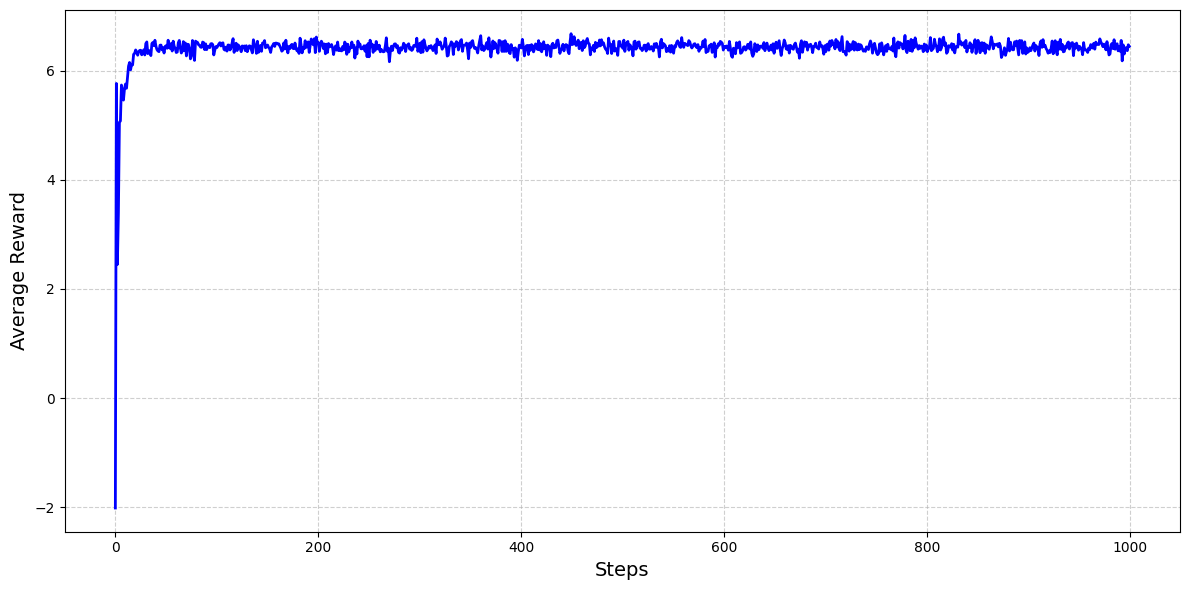

In [15]:
experiment = Experiment(CFG3)
experiment.run()
experiment.plot_average_rewards()

averaged_rewards_oiv_eps_0 = experiment.averaged_rewards

In [30]:
class CFG4:
  k = 10
  reward_means = torch.randint(-3, 8, (k,)).float()
  reward_stds = torch.rand(k) + 3.0
  eps = 0.0
  exploration = 'ucb' # upper-confidence bound
  c = 2
  iterations = 1000
  experiments = 2000

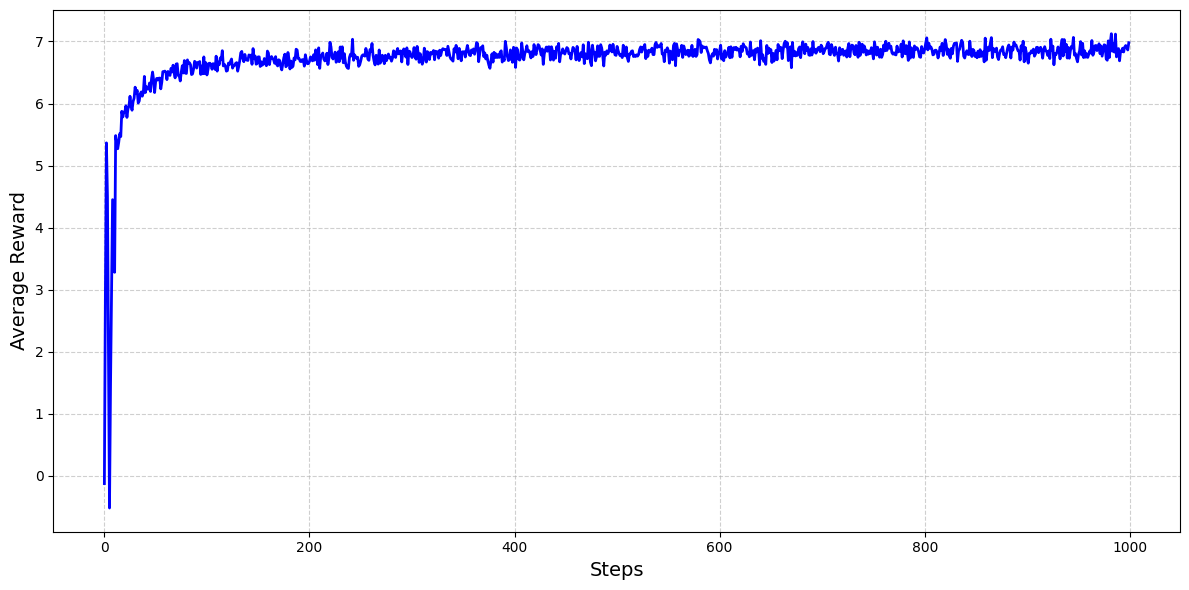

In [32]:
experiment = Experiment(CFG4)
experiment.run()
experiment.plot_average_rewards()

averaged_rewards_ucb_c_2 = experiment.averaged_rewards

In [18]:
import pickle

with open('results_12.pkl', 'rb') as f:
    results = pickle.load(f)

print(results)

{'experiment_1': {'exploration': 'epsilon-greedy', 'CFG': <class '__main__.CFG1'>, 'averaged_rewards': [np.float64(-2.357609000772238), np.float64(4.78598654705286), np.float64(5.5125853671729566), np.float64(6.093806611895562), np.float64(6.063501840561629), np.float64(6.086181157171726), np.float64(6.263527250260115), np.float64(6.188240961879492), np.float64(6.3132143123149875), np.float64(6.250569450318813), np.float64(6.2414697265625), np.float64(6.2687349230349065), np.float64(6.155493315368891), np.float64(6.349017325222492), np.float64(6.4150337023437025), np.float64(6.396153343230486), np.float64(6.38438283675909), np.float64(6.372915641844273), np.float64(6.338510043740272), np.float64(6.400412990450859), np.float64(6.432670993208885), np.float64(6.388805978506803), np.float64(6.5070212193131445), np.float64(6.35299676156044), np.float64(6.330522962480783), np.float64(6.186721239417792), np.float64(6.328075754910707), np.float64(6.470296416193247), np.float64(6.44780348432064

In [19]:
averaged_rewards_epsilon_greedy = results['experiment_1']['averaged_rewards']
averaged_rewards_greedy = results['experiment_2']['averaged_rewards']

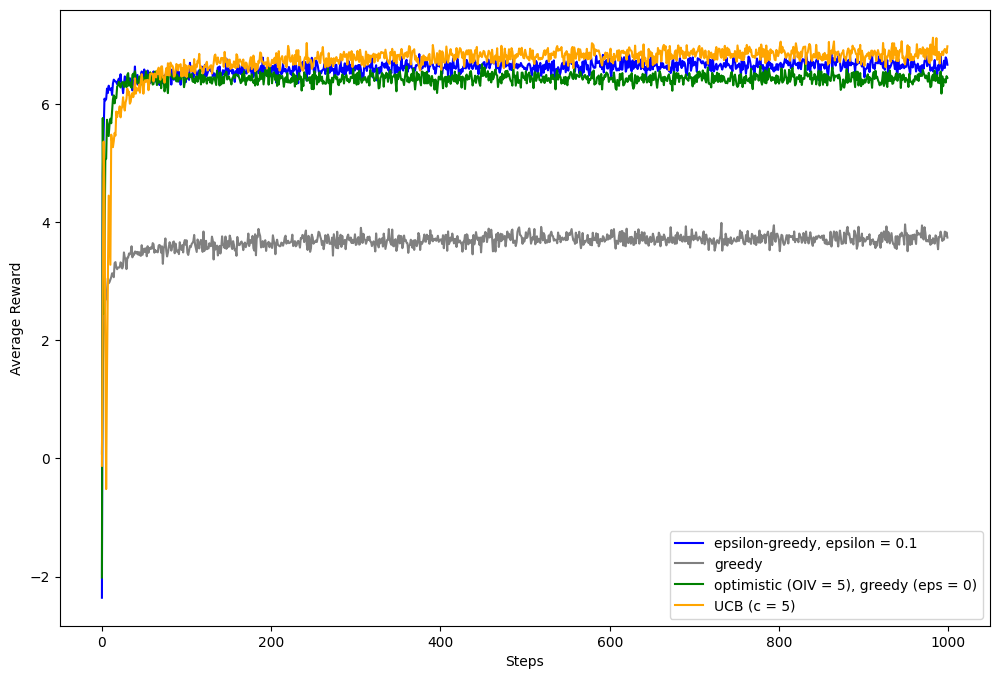

In [33]:
plt.figure(figsize=(12, 8))
plt.plot(averaged_rewards_epsilon_greedy, color='blue', label='epsilon-greedy, epsilon = 0.1')
plt.plot(averaged_rewards_greedy, color='grey', label='greedy')
plt.plot(averaged_rewards_oiv_eps_0, color='green', label='optimistic (OIV = 5), greedy (eps = 0)')
plt.plot(averaged_rewards_ucb_c_2, color='orange', label='UCB (c = 5)')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

In [34]:
results = {
    'experiment_3': {
        'exploration': 'oiv',
        'CFG': CFG3,
        'averaged_rewards': averaged_rewards_oiv_eps_0
    },
    'experiment_4': {
        'exploration': 'ucb',
        'CFG': CFG4,
        'averaged_rewards': averaged_rewards_ucb_c_2
    }
}

import pickle

with open('results_34.pkl', 'wb') as f:
    pickle.dump(results, f)